## Airline Passenger Volume

This model predicts the volume of airline passengers using historical data from January 1949 to December 1960, with a total of 144 observations. Even with this modest data set, surprisingly accurate predictions are possible. The data set is available on [Kaggle](https://www.kaggle.com/chirag19/air-passengers).

This is time series data, which is well suited to Long-Short Term Memory ([LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)).

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [0]:
# A convenience function to generate the current (X) and next (Y) sequence of data
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i, 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Training Data

The data is collected monthly, in units of 1000s of international passengers. The number of passengers expectedly increases with time. The data also appears cyclical, maybe due to holiday travel. LSTMs are capable of learning both features.

The data set is available on [Kaggle](https://www.kaggle.com/chirag19/air-passengers). It's in a zip file named air-passengers.zip, so you can unzip it using the following command.

In [4]:
!unzip air-passengers.zip

Archive:  air-passengers.zip
  inflating: AirPassengers.csv       


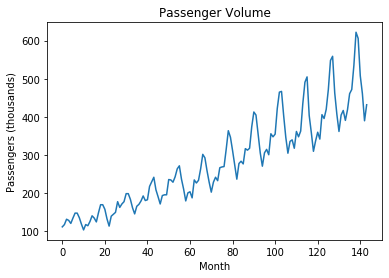

In [5]:
dataframe = pd.read_csv('AirPassengers.csv', usecols=[1], engine='python')
raw_data = dataframe.values.astype('float32')

plt.plot(raw_data)
plt.title('Passenger Volume')
plt.ylabel('Passengers (thousands)')
plt.xlabel('Month')
plt.show()

## Data Preparation

In [0]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(raw_data)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Create X=t and Y=t+1 datasets
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))

## Train Model

A simple, but effective model.

In [11]:
# Define and fit the LSTM network
model = Sequential()
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=1)

Train on 94 samples
Epoch 1/40
94/94 [==============================] - 1s 14ms/sample - loss: 0.0679
Epoch 2/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 3/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 4/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 5/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 6/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 7/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 8/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 9/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 10/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 11/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 12/40
94/94 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoc

## Model Loss

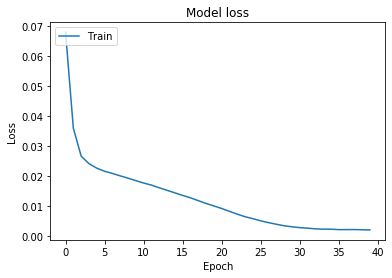

Minimum loss: 0.002


In [12]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
print("Minimum loss: %.3f" % history.history['loss'][-1])

## Prediction

In [9]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
invTrainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
invTestY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.20 RMSE
Test Score: 48.09 RMSE


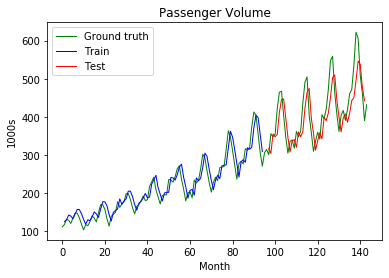

In [10]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot ground truth and predictions
plt.plot(scaler.inverse_transform(dataset), color='green', linewidth=1.0)
plt.plot(trainPredictPlot, color='blue', linewidth=1.0)
plt.plot(testPredictPlot, color='red', linewidth=1.0)
plt.title('Passenger Volume')
plt.ylabel('1000s')
plt.xlabel('Month')
plt.legend(['Ground truth', 'Train', 'Test'], loc='upper left')
plt.show()